In [5]:
import pandas as pd
import os
import plotnine as p9
import re
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import numpy as np
import  seaborn as sns

In [6]:
#Main functions I used:
# Reading the CSV files in any computer function:
def create_dataframe(path, name):
    for root, dirs, files in os.walk(path):
        if name in files:
            print(os.path.join(root, name))
            root = os.path.join(root, name)
            return root
# Getting Data out of Each row function
def get_description_data_per_row(df):
    "Creat a DF of all the encoded_panel_description in one of the rows"
    temp_list = df.split('+')
    material_id = []
    norm_thickness = []
    norm_areal_w = []
    norm_hardness = []
    smr =[]
    for mat_block in temp_list:
        temp_block = mat_block.split(';')

        material_id.append(temp_block[0])
        norm_thickness.append(temp_block[1])
        norm_areal_w.append(temp_block[2])
        norm_hardness.append(temp_block[3])
        smr.append(temp_block[4])

    description_data = pd.DataFrame({'material_id': material_id, 'norm_thickness': norm_thickness, 'norm_areal_w': norm_areal_w, 'norm_hardness': norm_hardness, 'smr': smr})
    number_of_layers = len(description_data)
    energy = 0
    for i in description_data.index:
        energy += Energy_of_mat(description_data.iloc[i].at['norm_thickness'],description_data.iloc[i].at['smr'],description_data.iloc[i].at['norm_areal_w'])
    return description_data,number_of_layers,energy

# Getting The energy out of each row function
def Energy_of_mat(thikness,smr,weight):
    rel_energy = 0
    for j in df_smr.index:
        if int(df_smr.iloc[j].at['smr_index']) == int(smr):
            rel_energy = (df_smr.iloc[j].at['p15']+df_smr.iloc[j].at['p10'] + df_smr.iloc[j].at['p5']* float(thikness) * float(weight))/3

    return rel_energy
# End of Functions

/Users/harlevido/PycharmProjects/materials Data/midterm/encrypted_batch_3.csv
/Users/harlevido/PycharmProjects/materials Data/midterm/encrypted_batch_3-smr.csv


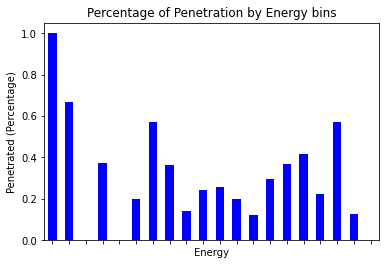

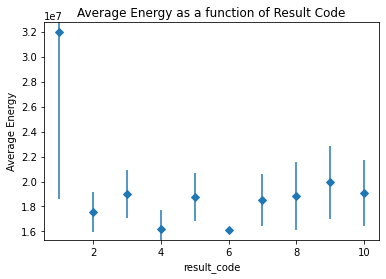

(-0.06289192796812466, 0.24886421209356027)


In [7]:

# Starting the analysis
##Reading the CSV files in any computer
df = pd.read_csv(create_dataframe(os.getcwd(),'encrypted_batch_3.csv'))
df_smr = pd.read_csv(create_dataframe(os.getcwd(),'encrypted_batch_3-smr.csv'))


# Assumption 1 - Is there a correlation between absorbed energy and shot penetrated:
df['Energy'] = ''
df['Nol'] = ''
for i in df.index:
    temp = get_description_data_per_row(df['encoded_panel_description'].iloc[i])
    df.at[i,'Energy'] = temp[2]
    df.at[i,'Nol'] = temp [1]

bin = (df['Energy'].max()-df['Energy'].min())/90 #(df['Energy'].median()--df['Energy'].min())/50
bins = []

for i in range(50):
    bins.append(df['Energy'].min() + i*bin)

s = pd.cut(df['Energy'], bins=bins).value_counts()
d = pd.cut(df[df['shot_penatration']==1]['Energy'], bins=bins).value_counts()
y = d/s

#Figure 1
ax = y[0:20].plot(kind = "bar", title = 'Percentage of Penetration by Energy bins', color = 'b')
ax.set_xlabel('Energy')
ax.set_ylabel('Penetrated (Percentage)')
plt.setp( ax.get_xticklabels(), visible=False)
plt.show()

ResVsE = df[['result_code','Energy']].groupby('result_code').agg([np.mean, np.std])
fig, ax1 = plt.subplots()

#Figure 2
ax1.errorbar(ResVsE.index, ResVsE['Energy']['mean'], yerr=ResVsE['Energy']['std']/2, fmt = 'D' )
ax1.set_xlabel('result_code')
ax1.set_ylabel('Average Energy')
plt.title('Average Energy as a function of Result Code')
plt.show()

#First Assumption pearson test
EvsPen = pearsonr(df['result_code'],df['Energy'])
print(EvsPen)



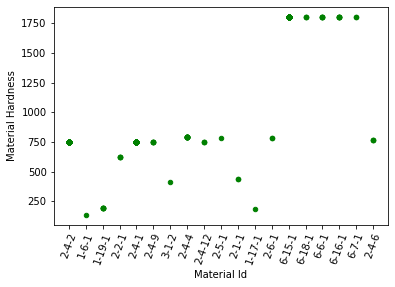

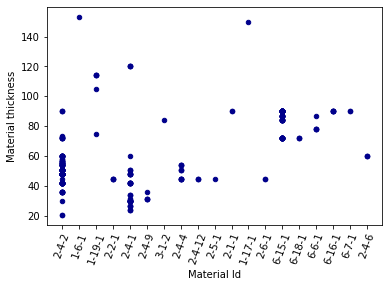

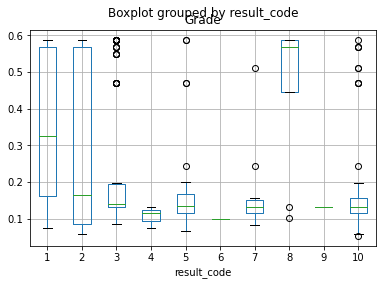

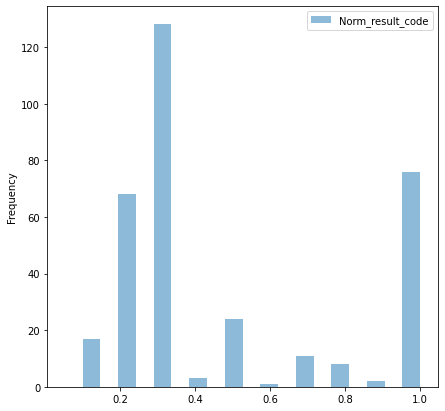

(-0.2131855456142165, 7.803558763014595e-05)


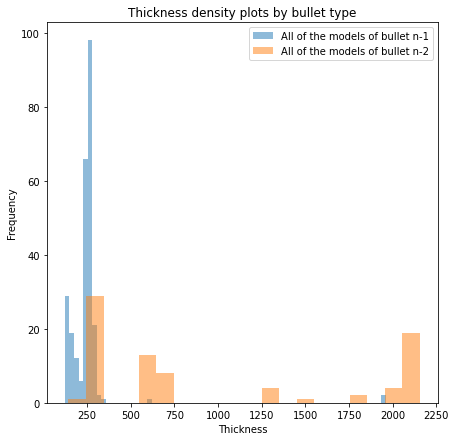

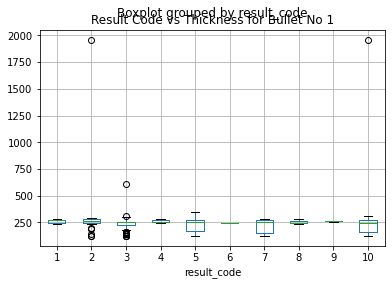

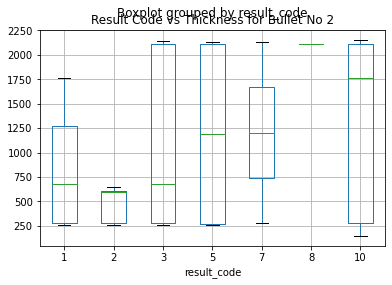

(0.3212997458402218, 0.0034476160733518542)


In [8]:

#Assumption 2 - The first layer's hardness and thickness is correlated with result_code

df['FL'] = ''
df['FLH'] = ''
df['Mid'] = ''

for i in df.index:
    temp = get_description_data_per_row(df['encoded_panel_description'].iloc[i])
    df.at[i,'FL'] = float(temp[0]['norm_thickness'].iloc[0])
    df.at[i,'FLH'] = float(temp[0]['norm_hardness'].iloc[0])
    df.at[i,'Mid'] = temp[0]['material_id'].iloc[0]

df['Grade'] = (df['FLH'] * df['FL'])/(df['FLH'].max() * df['FL'].max())
df['Norm_result_code'] = df['result_code']/df['result_code'].max()

#Figure 3
df.plot.scatter(x = 'Mid', y = 'FLH', c = 'Green')
plt.xticks(rotation = 70)
plt.xlabel('Material Id')
plt.ylabel('Material Hardness')
plt.show()

#Figure 4
df.plot.scatter(x = 'Mid', y = 'FL',c= 'DarkBlue')
plt.xticks( rotation = 70)
plt.xlabel('Material Id')
plt.ylabel('Material thickness')
plt.show()

#Figure 5
df.boxplot(by = 'result_code' , column = 'Grade' )
plt.show()

#Figure 6
df[['Grade','Norm_result_code']].plot.hist(figsize = (7, 7),bins = 20, alpha = 0.5,
                       linewidth = 4)
plt.show()
# Second Assumptions Pearson Test
HvsRes= pearsonr(df['Grade'],df['Norm_result_code'])
print(HvsRes)

#Assumption 3 - what is the different between the first and second bullet

fb = df[df['shot_bullet_type_encoded']==1]
sb = df[df['shot_bullet_type_encoded']==2]

#Figure 7
fb['normalized_thickness'].plot.hist(figsize = (7, 7),linewidth = 4,label = 'All of the models of bullet n-1',bins = 70, alpha = 0.5)
sb['normalized_thickness'].plot.hist(figsize = (7, 7),linewidth = 4,label = 'All of the models of bullet n-2',bins = 20, alpha = 0.5)
plt.xlabel('Thickness')
plt.title('Thickness density plots by bullet type')
plt.legend()
plt.show()

#Figure 8
fb.boxplot(by = 'result_code' , column = 'normalized_thickness' )
plt.title('Result Code vs Thickness for Bullet No 1')
plt.show()

#Figure 9
sb.boxplot(by = 'result_code' , column = 'normalized_thickness' )
plt.title('Result Code vs Thickness for Bullet No 2')
plt.show()


# Third Assumption pearson test
HvsRes= pearsonr(sb['result_code'],sb['normalized_thickness'])
print(HvsRes)


